# Control script for example 1 

### Import all packages from pymf6 

In [1]:
from pymf6.mf6 import MF6
from pymf6.api import States
import os 
from pathlib import Path 

In [2]:
from pymf6tools.plotting import show_well_head

In [3]:
MF6?

Init signature:
MF6(
    nam_file=None,
    sim_file='mfsim.nam',
    dll_path=None,
    use_modflow_api=True,
    verbose=False,
    _develop=False,
)
Docstring:      Wrapper around XmiWrapper.
File:           c:\tubaf\modsimple2\pymf6\src\pymf6\mf6.py
Type:           type
Subclasses:     

### Set model path and name 

In [4]:
dir = os.getcwd()
model_name = "example_1"
model_path = os.path.abspath(os.path.join(dir, 'models', model_name))
print(model_path)
nam_file = Path(os.path.join(model_path, 'mfsim.nam'))
nam_file

C:\TUBAF\MODSIMPLE2\pymf6tools\tests\models\example_1


WindowsPath('C:/TUBAF/MODSIMPLE2/pymf6tools/tests/models/example_1/mfsim.nam')

### Description of the control 

The pumping rate of the wells of the model are dynamically controlled by the groundwater level and the river stages.
### Vital river water levels
Vital river water levels are normally legislated by regional water management authorities. These organizations provide real-time data on the river levels and issue warnings in periods of flooding or low water levels. Further, the values also depend on the geometry of the river and local regulations. 
For the purpose of the demonstration, the minimum water level is 2,5 m. 
Keep in mind that is arbitrary value. 

### Control script 

In [5]:
def run_model(nam_file):
    print(nam_file)
    # Initialize the MF6 model using the provided nam file 
    mf6 = MF6(nam_file=nam_file)

    # Set tolerance and head limit values for control - groundwater and river threshold 
    tolerance = 0.01 # for the oscillation of the head for both thresholds  
    gw_head_limit = 0.5 # fixed threshold according to regulations 
    riv_head_limit = 0.5 # fixed threshold according to regulations 
    
    # limits for the groundwater 
    lower_limit_gw = gw_head_limit - tolerance
    upper_limit_gw = gw_head_limit + tolerance

    # limits for the river 
    lower_limit_riv = riv_head_limit - tolerance
    upper_limit_riv = riv_head_limit + tolerance
    
    # Variable to track if the water level has been below the groundwater limits 
    been_below_gw = False

    #Variable to track if the water level has been below the river threshold 
    been_below_riv = False  
    
    # List of wells with coordinates (layer, row, col)
    well_coords_list = [(0, 8, 4), (0, 13, 8), (0, 3, 9), (0, 9, 9), (0, 12, 7) ,(0, 3, 4)]
    
    # Dictionary to store information about each well 
    wells_info = {coords: {'been_below': False} for coords in well_coords_list}
    
    # Main simulation loop 
    for sim, state in mf6.loop:
        # Check if the start of a new time step 
        if state == States.timestep_start:
            # Get the model object 
            ml = sim.get_model()
            # Check if stress period (kper == 2)
            if ml.kper == 2:
                # Iteration over each well 
                for wel_coords, well_info in wells_info.items():
                    # Retrieve pumping rate and well head information
                    pumping = ml.wel.stress_period_data["flux"]
                    wel_head = ml.X.__getitem__(wel_coords)
                    wel_bc = ml.wel.stress_period_data
                    
                    # Retrieve river stages 
                    river_stage = ml.riv.stress_period_data["stage"]

                    # maximum and miminum values of the river stages in the model 
                    max_river_stage = max(river_stage)
                    min_river_stage = min(river_stage)

                    # Difference betwen the maximum and minimum if the regulations are based on the diffrences of the water level instead of the water levels
                    diff_river = max_river_stage - min_river_stage

                    #Adjust pumping rate if the well head is below the lower limit 
                    if wel_head <= lower_limit_gw:
                        wel_bc["flux"] = pumping * 0.9
                        been_below_gw = True
                        
                    # Adjust pumping rate if the well head is above the limit 
                    elif been_below_gw and wel_head >= upper_limit_gw:
                        wel_bc["flux"] = pumping * 1.1
                    
                    # Adjust pumping rate if the well head is below the river stage lower limit 
                    if diff_river <= lower_limit_riv:
                        wel_bc["flux"] = pumping * 0.9
                        been_below_riv = True
                        
                    # Adjust pumping rate if the well head is above the limit 
                    elif been_below_riv and diff_river >= upper_limit_riv:
                        wel_bc["flux"] = pumping * 1.1
                        

if __name__ == '__main__':
    run_model(nam_file)
    print('done')

C:\TUBAF\MODSIMPLE2\pymf6tools\tests\models\example_1\mfsim.nam
NORMAL TERMINATION OF SIMULATION
done


UFuncTypeError: ufunc 'multiply' did not contain a loop with signature matching types (dtype('int32'), dtype((numpy.record, [('node', '<i4'), ('node2', '<i4'), ('q', '<f8'), ('qx', '<f8'), ('qy', '<f8'), ('qz', '<f8')]))) -> None

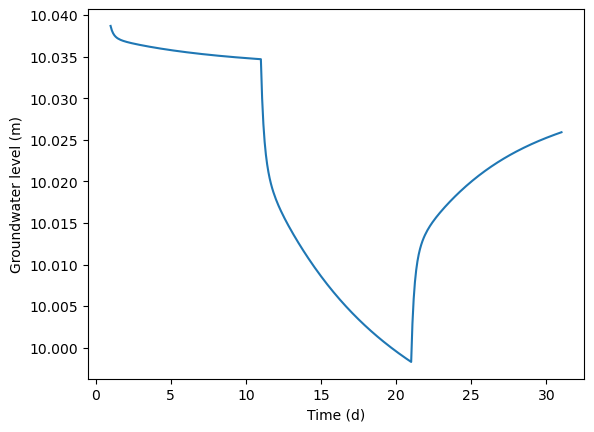

In [6]:
# needs modifications to aport all the wells 
show_well_head(wel_coords= (0, 8, 4), model_path=model_path, exe_model=None, times=2)